#Caso de Estudio: Clasificación de Cubiertas Urbanas en Quimbaya

Este caso de estudio consiste en la clasificación de cubiertas en el municipio de Quimbaya (Quindío), identificando tres materiales principales: zinc, eternit y barro, mediante redes neuronales convolucionales (CNN). La metodología es patch-based, por lo que no se trata de segmentación, sino de la clasificación de ventanas de la imagen, donde cada ventana recibe una única categoría según el material predominante.

## Cargue librerias

In [2]:
%%capture
!pip install -q gdown
!pip install rasterio

In [1]:
import re
import os
import zipfile
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import rasterize
from pathlib import Path
from rasterio import features
from rasterio.windows import Window
from shapely.geometry import Point

## Lectura y exploración de datos

Se descarga un archivo ZIP desde Google Drive usando su ID, evita que se muestren mensajes en pantalla y luego descomprime el archivo en la carpeta de trabajo para poder usar su contenido.

In [38]:
%%capture
# Enlace: https://drive.google.com/file/d/1jk2xewitB2zNsCygPpVC0mfhIOq4m5Wq/view?usp=sharing
file_id = "1jk2xewitB2zNsCygPpVC0mfhIOq4m5Wq"
output_zip = "/content/Recurso_D2M1_4_NCC.zip"

# Descargardesde Google Drive
!gdown --id {file_id} -O {output_zip}

!unzip -o {output_zip} -d /content/



In [39]:
# remover zip
!rm /content/*.zip

Se abre el archivo ráster y muestra información básica sobre él, como su tamaño, número de bandas, sistema de referencia, resolución, extensión y metadatos.





In [40]:
raster_path = "/content/Recurso_D2M1_4_NCC/63594quimbaya_clip15.tif"

# Abrir el archivo raster
with rasterio .open(raster_path) as src:
    print("=== Información del Raster ===")
    print(f"Ancho: {src.width}")
    print(f"Alto: {src.height}")
    print(f"Bandas: {src.count}")
    print(f"CRS: {src.crs}")
    print(f"Resolución: {src.res}")
    print(f"Extensión: {src.bounds}")
    print("\nMetadatos:")
    print(src.meta)

=== Información del Raster ===
Ancho: 13028
Alto: 9593
Bandas: 4
CRS: ESRI:103599
Resolución: (0.1500000000000143, 0.14999999999999514)
Extensión: BoundingBox(left=4692574.955925823, bottom=2068982.7237181857, right=4694529.155925823, top=2070421.6737181856)

Metadatos:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 13028, 'height': 9593, 'count': 4, 'crs': CRS.from_wkt('PROJCS["MAGNA_SIRGAS_Origen_Nacional",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 't

Cargar el shapefile ubicado en la ruta indicada y lo muestra como un GeoDataFrame para visualizar sus atributos y geometrías.

In [41]:
shp_path = "/content/Recurso_D2M1_4_NCC/label_QB.shp"

gdf_label= gpd.read_file(shp_path)
gdf_label


,OBJECTID,value,ORIG_OID,STATUS,Shape_Leng,Shape_Area,LABEL,geometry
0,57,255.0,56,0,35.740883,60.250324,ZINC,"POLYGON ((4694132.752 2070408.579, 4694134.663..."
1,103,255.0,102,0,36.486579,77.124912,ETERNIT,"POLYGON ((4694121.346 2070316.036, 4694121.484..."
2,109,255.0,108,0,48.864793,93.164982,ZINC,"POLYGON ((4694267.046 2070321.491, 4694267.294..."
3,111,255.0,110,0,49.691764,116.607302,ZINC,"POLYGON ((4694230.52 2070306.133, 4694230.269 ..."
4,128,255.0,127,0,71.841828,151.774775,ETERNIT,"POLYGON ((4694192.576 2070275.201, 4694192.517..."
...,...,...,...,...,...,...,...,...
188,7975,0.0,0,0,110.390446,262.744783,ETERNIT,"POLYGON ((4694244.193 2070250.102, 4694249.947..."
189,7980,0.0,0,0,119.045646,327.981508,ETERNIT,"POLYGON ((4694246.914 2070237.35, 4694273.042 ..."
190,7981,0.0,0,0,55.304781,142.729171,ETERNIT,"POLYGON ((4694313.933 2070223.195, 4694334.412..."
191,7982,0.0,0,0,73.607354,189.066711,ETERNIT,"POLYGON ((4694281.535 2070189.103, 4694288.48 ..."


In [42]:
gdf_label.crs

<Projected CRS: PROJCS["MAGNA_SIRGAS_Origen_Nacional",GEOGCS["MAGN ...>
Name: MAGNA_SIRGAS_Origen_Nacional
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Se revisa cuántas etiquetas existen y cuántos polígonos hay en cada categoría del campo LABEL.

In [43]:
gdf_label['LABEL'].value_counts()

,count
LABEL,
BARRO,89
ZINC,68
ETERNIT,36


Se revisan estadísticas generales de los datos.

In [44]:
gdf_label.describe()

,OBJECTID,value,ORIG_OID,STATUS,Shape_Leng,Shape_Area
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,4079.093264,231.217617,3378.212435,0.005181,58.358906,136.305631
std,2352.125881,74.347469,2277.706058,0.071982,35.595478,115.786074
min,0.000000,0.000000,0.000000,0.000000,0.000000,60.250286
25%,2175.000000,255.000000,1720.000000,0.000000,40.799853,76.560087
50%,3702.000000,255.000000,3234.000000,0.000000,47.962327,100.479779
75%,6406.000000,255.000000,4983.000000,0.000000,60.399976,148.050097
max,7982.000000,255.000000,7240.000000,1.000000,286.098595,992.269887


La resolución es **15 cm**, o sea **0.15 m** por píxel.

Cada píxel tiene un área de 0.15\,m \times 0.15\,m = 0.0225\,m^2 el poligono más pequeño tiene un área de $60m^2$ el número de píxeles.


$$\frac{60\,m^2}{0.0225\,m^2/pixel} = 2666.666\ldots$$

Aproximadamente **2667 píxeles**.

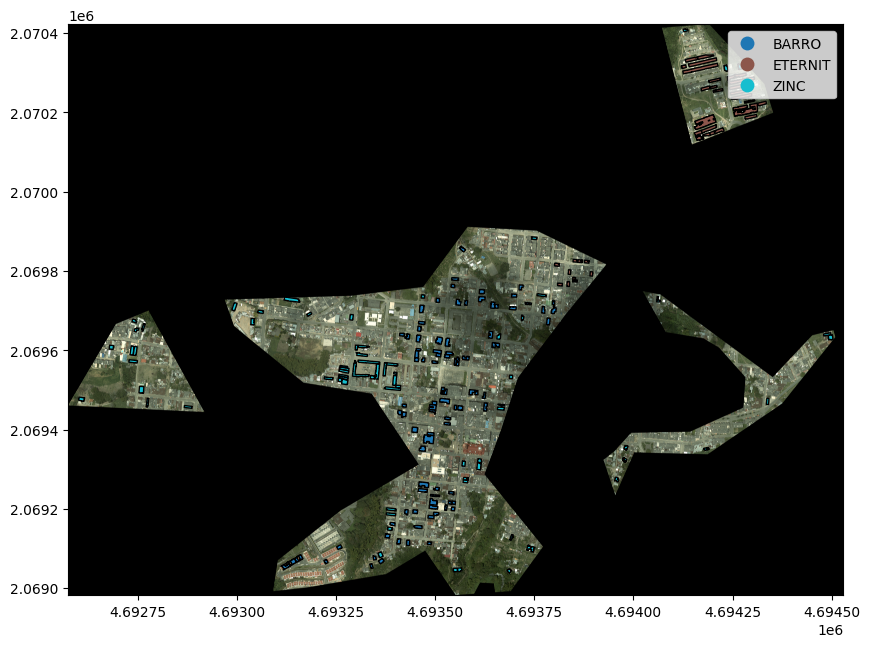

In [45]:
raster = rasterio .open(raster_path)
fig, ax = plt.subplots(figsize=(10,10))
show(raster, ax=ax, cmap='gray')
gdf_label.plot(ax=ax, column='LABEL', legend=True, linewidth=1, edgecolor='black')


plt.show()

## Construcción conjunto de datos

Se define los insumos y configuraciones necesarias para extraer parches (ventanas) desde una imagen ráster y asociarlos con etiquetas de un archivo vectorial. Estos parches serán usados como datos de entrenamiento para una red neuronal convolucional (CNN).

**Parámetros de muestreo**

- **window_size**: tamaño de la ventana de muestreo en píxeles (64x64).
- **half_window**: ayuda a centrar correctamente cada ventana con respecto al píxel objetivo.
- **stride**: distancia entre ventanas. Un stride menor que el tamaño de la ventana genera solapamiento y más muestras.
- **label_field**: nombre del campo en el shapefile que almacena la clase del polígono.


In [4]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
raster_path ='/content/Recurso_D2M1_4_NCC/63594quimbaya_clip15.tif'
gdf_label = gpd.read_file('/content/Recurso_D2M1_4_NCC/label_QB.shp')

# parámetros de la ventana
window_size = 64
half_window = window_size // 2
stride = 32
label_field = 'LABEL'

print(f"ventana de: {window_size}x{window_size} píxeles")
print(f"paso (stride): {stride} píxeles")

X_data = []  # datos de entrada(n, 64, 64, 4)
Y_labels = []

ventana de: 64x64 píxeles
paso (stride): 32 píxeles


In [15]:
try:
    with rasterio.open(raster_path) as src:

        print(f"Dimensiones: {src.width}x{src.height}")
        print(f"Bandas: {src.count}")


        for index, row in gdf_label.iterrows():
            polygon_geom = row.geometry
            label_value = row[label_field]

            # Rejilla de muestreo basada en el ráster y el polígono
            minx, miny, maxx, maxy = polygon_geom.bounds

            # Obtener los índices de píxel del Bounding Box (BB) del polígono
            row_start_bb, col_start_bb = src.index(minx, maxy) # Esquina superior izquierda
            row_end_bb, col_end_bb = src.index(maxx, miny)     # Esquina inferior derecha

            # Definir los límites de la rejilla para que el parche de 64x64 quepa
            # La columna/fila del centro debe estar al menos a HALF_WINDOW del borde del ráster
            col_min = max(half_window, col_start_bb)
            col_max = min(src.width - half_window, col_end_bb)
            row_min = max(half_window, row_start_bb)
            row_max = min(src.height - half_window, row_end_bb)

            count_patches = 0

            # Iterar a través de los centros de las columnas (c) y filas (r) con el Stride
            for col_center in range(col_min, col_max, stride):
                for row_center in range(row_min, row_max, stride):

                    # Convertir el centro de píxel a coordenadas CRS (geográficas)
                    center_x_crs, center_y_crs = src.xy(row_center, col_center)

                    # Verifica centro cae dentro del polígono?
                    if polygon_geom.contains(Point(center_x_crs, center_y_crs)):

                        # efinir la ventana de 64x64 centrada en (row_center, col_center)
                        col_off = col_center - half_window
                        row_off = row_center - half_window
                        window = Window(col_off, row_off, window_size, window_size)

                        # src.read() retorna (Bandas, Filas, Columnas)
                        window_data = src.read(window=window)



                        # Transponer a (Filas, Columnas, Bandas) -> (64, 64, 4)
                        window_data = np.transpose(window_data, (1, 2, 0))

                        # Almacenar
                        X_data.append(window_data)
                        Y_labels.append(label_value)
                        count_patches += 1

            print(f" -> Polígono {index} ('{label_value}') generó {count_patches} parches.")

finally:
    pass



Dimensiones: 13028x9593
Bandas: 4
 -> Polígono 0 ('ZINC') generó 2 parches.
 -> Polígono 1 ('ETERNIT') generó 2 parches.
 -> Polígono 2 ('ZINC') generó 3 parches.
 -> Polígono 3 ('ZINC') generó 4 parches.
 -> Polígono 4 ('ETERNIT') generó 7 parches.
 -> Polígono 5 ('ETERNIT') generó 17 parches.
 -> Polígono 6 ('ETERNIT') generó 3 parches.
 -> Polígono 7 ('ETERNIT') generó 4 parches.
 -> Polígono 8 ('ETERNIT') generó 4 parches.
 -> Polígono 9 ('ETERNIT') generó 10 parches.
 -> Polígono 10 ('ETERNIT') generó 33 parches.
 -> Polígono 11 ('ETERNIT') generó 42 parches.
 -> Polígono 12 ('ETERNIT') generó 6 parches.
 -> Polígono 13 ('ETERNIT') generó 4 parches.
 -> Polígono 14 ('ZINC') generó 2 parches.
 -> Polígono 15 ('BARRO') generó 5 parches.
 -> Polígono 16 ('ETERNIT') generó 2 parches.
 -> Polígono 17 ('ETERNIT') generó 1 parches.
 -> Polígono 18 ('ETERNIT') generó 2 parches.
 -> Polígono 19 ('ETERNIT') generó 2 parches.
 -> Polígono 20 ('ETERNIT') generó 2 parches.
 -> Polígono 21 ('BA

In [16]:
# Convertir listas a arrays de numpy
X_array= np.array(X_data, dtype=np.float32)
Y_array = np.array(Y_labels)

print(f"Total de Ventanas generadas: {len(X_array)}")
print(f"Forma de los datos X (entrada): {X_array.shape} (N, 64, 64, 4)")




Total de Ventanas generadas: 915
Forma de los datos X (entrada): (915, 64, 64, 4) (N, 64, 64, 4)


In [17]:
unique_labels, counts = np.unique(Y_array, return_counts=True)
for label, count in zip(unique_labels, counts):
        print(f"  - '{label}': {count} parches")

  - 'BARRO': 332 parches
  - 'ETERNIT': 304 parches
  - 'ZINC': 279 parches


In [18]:
X_array[1].shape

(64, 64, 4)

In [19]:
X_array[1][:,:,0]

array([[ 69.,  73.,  74., ..., 117., 122., 121.],
       [ 65.,  69.,  67., ..., 123., 118., 119.],
       [ 87., 102., 112., ..., 126., 123., 125.],
       ...,
       [213., 231., 236., ...,  34.,  37.,  29.],
       [213., 216., 212., ...,  49.,  48.,  47.],
       [186., 176., 153., ...,  46.,  37.,  26.]], dtype=float32)

In [54]:
np.save('/content/X_quimbaya.npy', X_array)
np.save('/content/Y_quimbaya.npy', Y_array)


In [26]:
total_wind = len(X_array)

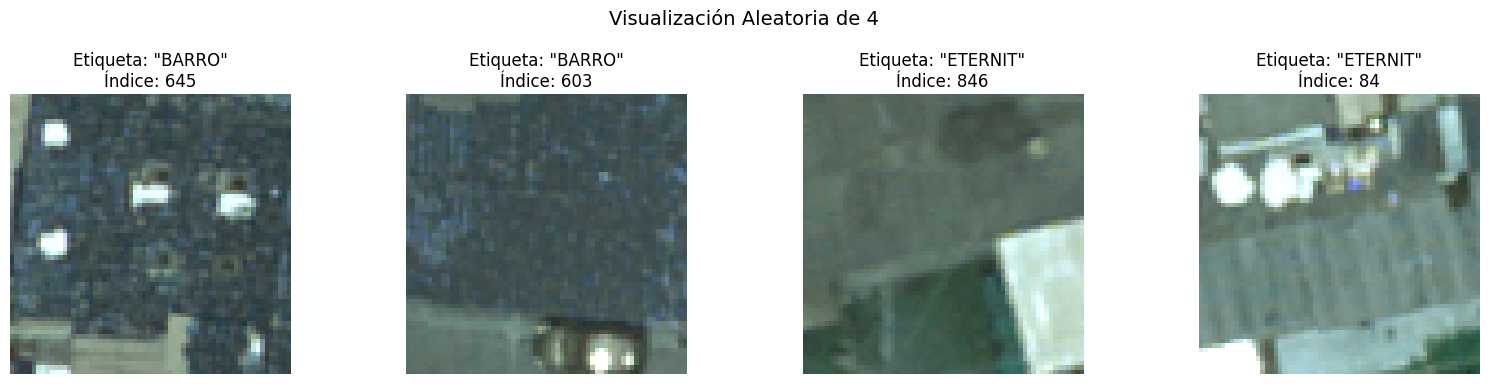

In [27]:
R_BAND = 2
G_BAND = 1
B_BAND = 0


# Configuración de la visualización
num_wind = 4  # Número de parches aleatorios a mostrar
total_wind = len(X_array)

if total_wind  == 0:
    print("No se extrajeron parches para visualizar.")
else:
    #
    # Elegir num_wind índices únicos de forma aleatoria
    num_samples = min(num_wind, total_wind)
    random_indices = np.random.choice(total_wind, size=num_samples, replace=False)


    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
    if num_samples == 1:
        axes = [axes]

    fig.suptitle(f'Visualización Aleatoria de {num_samples}', fontsize=14)

    #
    for i, index in enumerate(random_indices):

        patch = X_array[index]
        label = Y_array[index]  # Obtener la etiqueta correspondiente


        # Seleccionar las bandas R, G, B
        rgb_composite = patch[:, :, [R_BAND, G_BAND, B_BAND]]
        rgb_composite = rgb_composite / 255.0


        # MOSTRAR EL PARCHE
        ax = axes[i]
        ax.imshow(rgb_composite)
        ax.set_title(f'Etiqueta: "{label}"\nÍndice: {index}')
        ax.axis('off') # Quitar ejes

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Transformar  las etiquetas en números y luego en formato one-hot para que la red neuronal pueda usarlas.

In [28]:
label_encoder = LabelEncoder()
Y_integers = label_encoder.fit_transform(Y_array)
Y_one_hot = to_categorical(Y_integers)
num_class = Y_one_hot.shape[1]



In [29]:
for i, clase in enumerate(label_encoder.classes_):
    print(i, clase)

0 BARRO
1 ETERNIT
2 ZINC


In [30]:
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(
    X_array, Y_one_hot, test_size=0.2, random_state=42
)

print(f"Dimensiones X_train: {X_train_raw.shape}")
print(f"Dimensiones X_test: {X_test_raw.shape}")
print(f"Dimensiones Y_train: {Y_train.shape}")
print(f"Dimensiones Y_test: {Y_test.shape}")

Dimensiones X_train: (732, 64, 64, 4)
Dimensiones X_test: (183, 64, 64, 4)
Dimensiones Y_train: (732, 3)
Dimensiones Y_test: (183, 3)


In [31]:
#Dimensiones originales de los parches
N_train, H, W, C = X_train_raw.shape

In [32]:
#Reformar X_train_raw de (N, H, W, C) a (N, H*W*C)
X_train_reshaped = X_train_raw.reshape(N_train, H * W * C).astype('float32')
X_test_reshaped = X_test_raw.reshape(X_test_raw.shape[0], H * W * C).astype('float32')


In [33]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

In [34]:
X_train = X_train_scaled.reshape(N_train, H, W, C)
X_test = X_test_scaled.reshape(X_test_raw.shape[0], H, W, C)

In [36]:
print(f"Dimensiones X_train (normalizado): {X_train.shape}")
print(f"Dimensiones X_test (normalizado): {X_test.shape}")

Dimensiones X_train (normalizado): (732, 64, 64, 4)
Dimensiones X_test (normalizado): (183, 64, 64, 4)


In [35]:
 X_train.shape[1:]

(64, 64, 4)

In [37]:
print(X_train.shape[1:] )

(64, 64, 4)


## Entrenamiento

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [42]:
input_shape = X_train.shape[1:]
print(input_shape)

(64, 64, 4)


In [40]:
model= Sequential([
    # Primera capa convolucional con activación ReLU y zancadas de 1
    Conv2D(128, (5, 5), activation='relu', input_shape=input_shape, padding='same', strides=(1, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda capa convolucional con activación Sigmoid y zancadas de 1
    Conv2D(64, (5, 5), activation='sigmoid', padding='same', strides=(1, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    # Tercera capa convolucional con activación Tanh
    Conv2D(32, (5,5), activation='tanh', padding='same'),

    # Normalización por lotes
    BatchNormalization(),

    # Aplanar para conectar con la capa densa
    Flatten(),

    # Capa densa con activación ReLU
    Dense(32, activation='relu'),

    # Capa de salida con activación Softmax (para clasificación multiclase)
    Dense(num_class, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,427 (2.03 MB)

 Trainable params: 531,363 (2.03 MB)

 Non-trainable params: 64 (256.00 B)

In [43]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, Y_test)
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4565 - loss: 1.8809 - val_accuracy: 0.3934 - val_loss: 1.0271
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6517 - loss: 0.7491 - val_accuracy: 0.3279 - val_loss: 1.8341
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8473 - loss: 0.3809 - val_accuracy: 0.4481 - val_loss: 2.0291
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9057 - loss: 0.2470 - val_accuracy: 0.6503 - val_loss: 0.8614
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9095 - loss: 0.1986 - val_accuracy: 0.6885 - val_loss: 0.7075
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9651 - loss: 0.1063 - val_accuracy: 0.8525 - val_loss: 0.3191
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9301 - loss: 0.1762 - val_accuracy: 0.6721 - val_loss: 0.7639
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9577 - loss: 0.1397 - val_accuracy: 0.9016 - val_loss:

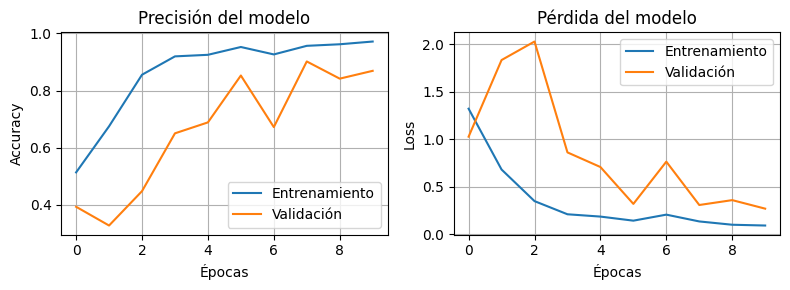

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(history.history['accuracy'], label='Entrenamiento')
ax[0].plot(history.history['val_accuracy'], label='Validación')
ax[0].set_title('Precisión del modelo')
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history.history['loss'], label='Entrenamiento')
ax[1].plot(history.history['val_loss'], label='Validación')
ax[1].set_title('Pérdida del modelo')
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)


plt.tight_layout()
plt.show()

In [45]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 671ms/step


Reporte de clasificación:
              precision    recall  f1-score   support

       BARRO       0.99      0.99      0.99        68
     ETERNIT       0.73      0.98      0.84        60
        ZINC       0.97      0.60      0.74        55

    accuracy                           0.87       183
   macro avg       0.89      0.86      0.85       183
weighted avg       0.90      0.87      0.86       183



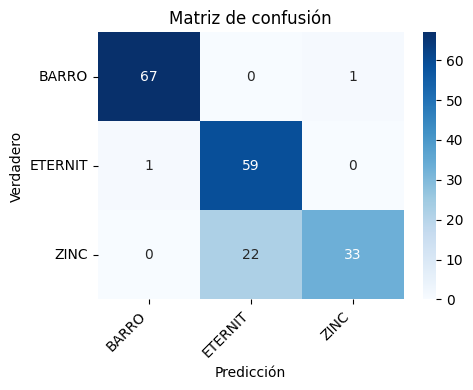

In [46]:
class_names = label_encoder.classes_


print('Reporte de clasificación:')
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Precisión alta (0.97):** Casi todas las veces que el modelo predice “ZINC”, acierta.
Es decir, pocas predicciones falsas positivas.

**Recall bajo (0.60)**:El modelo no detecta todas las muestras reales de “ZINC”. Es decir, muchas falsas negativas (casos que eran ZINC pero el modelo no los reconoció).

## Predicción

In [47]:
import rasterio
import numpy as np
from rasterio.windows import Window
import tensorflow as tf

In [49]:

raster_path = '/content/Recurso_D2M1_4_NCC/63594quimbaya_clip15.tif'
OUTPUT_PATH = '/content/mapa_clasificado_opt.tif' # Cambiado para no sobrescribir el anterior
WINDOW_SIZE = 64
HALF_WINDOW = 32
STRIDE = 32
NUM_CLASSES = 3


# El número de parches que se procesarán en una sola predicción por lotes.
PREDICTION_BATCH_SIZE = 1024

def predict_and_save_raster_optimized(raster_path, output_path, model, window_size, stride):
    """
    Realiza la clasificación por ventana, procesando en lotes para optimizar el uso de memoria.
    """

    def process_and_write_batch(batch_list, classification_map, dst, model, window_size):
        """Convierte la lista de parches en un array, predice, y escribe los resultados."""
        if not batch_list:
            return 0

        # Crear el array 4D para predicción en lote
        X_predict = np.array([item[0] for item in batch_list])
        coords = [item[1] for item in batch_list] # Coordenadas (row_off, col_off)

        # Predecir en Lote
        predictions_probs = model.predict(X_predict, verbose=0)

        # Obtener las clases predichas
        # SUMAMOS +1 si nuestras clases en el ráster empiezan en 1 (ej: 1, 2, 3)
        predicted_classes = np.argmax(predictions_probs, axis=1) + 1

        # Escribir las predicciones en el mapa de clasificación
        for i, (row_off, col_off) in enumerate(coords):

            predicted_class = predicted_classes[i]

            # Cálculo de tamaño para bordes
            window_size_h = min(window_size, classification_map.shape[0] - row_off)
            window_size_w = min(window_size, classification_map.shape[1] - col_off)

            # Escribir la clase predicha en el área del parche
            classification_map[row_off:row_off + window_size_h, col_off:col_off + window_size_w] = predicted_class

        return len(batch_list)


    # INICIO DE LA FUNCIÓN PRINCIPAL


    patches_list = []
    total_predicted = 0

    with rasterio.open(raster_path) as src:

        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1, nodata=0)

        with rasterio.open(output_path, 'w', **profile) as dst:

            classification_map = np.zeros((src.height, src.width), dtype=np.uint8)

            print(f"Iniciando clasificación. Tamaño del lote de predicción: {PREDICTION_BATCH_SIZE}")

            # Iterar a través de las ventanas (parches)
            for row_center in range(HALF_WINDOW, src.height - HALF_WINDOW, STRIDE):
                for col_center in range(HALF_WINDOW, src.width - HALF_WINDOW, STRIDE):

                    # DEFINICIÓN Y EXTRACCIÓN DEL PARCHE
                    row_off = row_center - HALF_WINDOW
                    col_off = col_center - HALF_WINDOW
                    window = Window(col_off, row_off, WINDOW_SIZE, WINDOW_SIZE)
                    patch_data_raw = src.read(window=window)

                    if np.any(patch_data_raw != src.nodata):



                        # Normalización
                        try:
                            max_val = np.iinfo(patch_data_raw.dtype).max
                        except ValueError:
                            max_val = 1.0

                        patch_data_float = patch_data_raw.astype('float32')
                        patch_data_norm = patch_data_float / max_val

                        # Transposición a (H, W, Bandas)
                        patch_data_norm = np.transpose(patch_data_norm, (1, 2, 0))

                        # ALMACENAR Y VERIFICAR LÍMITE
                        patches_list.append((patch_data_norm, (row_off, col_off)))

                        # PREDECIR Y BORRAR LOTE
                        if len(patches_list) >= PREDICTION_BATCH_SIZE:
                            total_predicted += process_and_write_batch(
                                patches_list, classification_map, dst, model, window_size
                            )
                            patches_list = [] # ¡Liberar memoria del lote!
                            print(f"-> Predichos y escritos: {total_predicted} parches...")


            # Procesar el Lote Final (si queda algo en la lista)
            if patches_list:
                print("Procesando lote final...")
                total_predicted += process_and_write_batch(
                    patches_list, classification_map, dst, model, window_size
                )

            # Escribir la matriz de clasificación final al archivo
            dst.write(classification_map, 1)

    print(f"\Clasificación completada ({total_predicted} parches) y guardada en: {output_path}")

# --- EJECUCIÓN (Asegúrate de que 'model' esté disponible) ---
if 'model' in locals():
    predict_and_save_raster_optimized(raster_path, OUTPUT_PATH, model, WINDOW_SIZE, STRIDE)
else:
    print("Error: El objeto 'model' (el modelo CNN entrenado) no está disponible.")

<>:113: SyntaxWarning: invalid escape sequence '\C'
<>:113: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipython-input-3518846525.py:113: SyntaxWarning: invalid escape sequence '\C'
  print(f"\Clasificación completada ({total_predicted} parches) y guardada en: {output_path}")


Iniciando clasificación. Tamaño del lote de predicción: 1024
-> Predichos y escritos: 1024 parches...
-> Predichos y escritos: 2048 parches...
-> Predichos y escritos: 3072 parches...
-> Predichos y escritos: 4096 parches...
-> Predichos y escritos: 5120 parches...
-> Predichos y escritos: 6144 parches...
-> Predichos y escritos: 7168 parches...
-> Predichos y escritos: 8192 parches...
-> Predichos y escritos: 9216 parches...
-> Predichos y escritos: 10240 parches...
-> Predichos y escritos: 11264 parches...
-> Predichos y escritos: 12288 parches...
-> Predichos y escritos: 13312 parches...
-> Predichos y escritos: 14336 parches...
-> Predichos y escritos: 15360 parches...
-> Predichos y escritos: 16384 parches...
-> Predichos y escritos: 17408 parches...
-> Predichos y escritos: 18432 parches...
-> Predichos y escritos: 19456 parches...
-> Predichos y escritos: 20480 parches...
-> Predichos y escritos: 21504 parches...
-> Predichos y escritos: 22528 parches...
-> Predichos y escritos:

<Axes: >

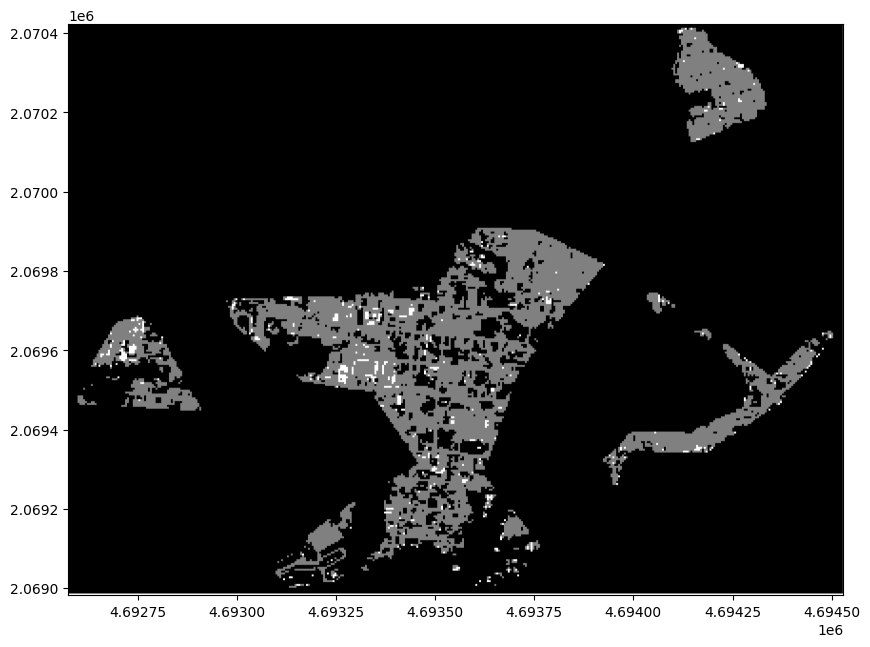

In [50]:
raster = rasterio.open('/content/mapa_clasificado_opt.tif')
fig, ax = plt.subplots(figsize=(10,10))
show(raster, ax=ax, cmap='gray')